# 5.1 Generalization


train_images shape:	(60000, 784)
test_images shape:	(10000, 28, 28)


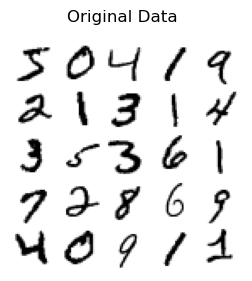

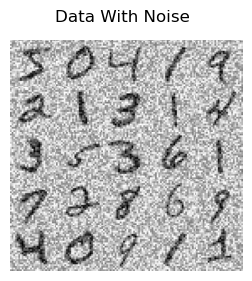

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data(path="mnist.npz")
)

train_images = train_images.reshape(
    train_images.shape[0], train_images.shape[1] * train_images.shape[2]
)
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1
)

train_images_with_noise = np.add(
    train_images, np.random.random((len(train_images), 784))
)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1
)

print(
    f"train_images shape:\t{train_images.shape}\ntest_images shape:\t{test_images.shape}"
)


def plot_digit(image_array):
    image = image_array.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


plt.figure(figsize=(3, 3))
for idx, image_data in enumerate(train_images[:25]):
    plt.subplot(5, 5, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Original Data")
plt.show()

plt.figure(figsize=(3, 3))
for idx, image_data in enumerate(train_images_with_noise[:25]):
    plt.subplot(5, 5, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Data With Noise")
plt.show()

## 5.1.1 Underfitting and Overfitting

Noisy features are prone to overfitting.

### Helper function


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.facecolor"] = "darkgray"
mpl.rcParams["axes.facecolor"] = "white"


def fit_and_plot_results(
    model,
    x_train,
    y_train,
    n_epochs=20,
    batch_size=512,
    val_ratio=0.4,
    verbose=0,
    title="",
    loss_only=False,
    axes=None,
    start_at_idx=0,
):
    history = model.fit(
        x_train,
        y_train,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=val_ratio,
        verbose=verbose,
    )
    history_dct = history.history

    loss_values = history_dct["loss"][start_at_idx:]
    val_loss_values = history_dct["val_loss"][start_at_idx:]
    acc = history_dct["accuracy"][start_at_idx:]
    val_acc = history_dct["val_accuracy"][start_at_idx:]
    epochs = range(1, len(loss_values) + 1)

    # First subplot (Training and validation loss)
    axes[0].plot(epochs, loss_values, "b--", label="Training Loss")
    axes[0].plot(epochs, val_loss_values, "r", label="Validation Loss")
    axes[0].set_title(f"{title} - Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    if not loss_only:
        # Second subplot (Training and validation accuracy)
        axes[1].plot(epochs, acc, "b--", label="Training Accuracy")
        axes[1].plot(epochs, val_acc, "r", label="Validation Accuracy")
        axes[1].set_title(f"{title} - Accuracy")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()

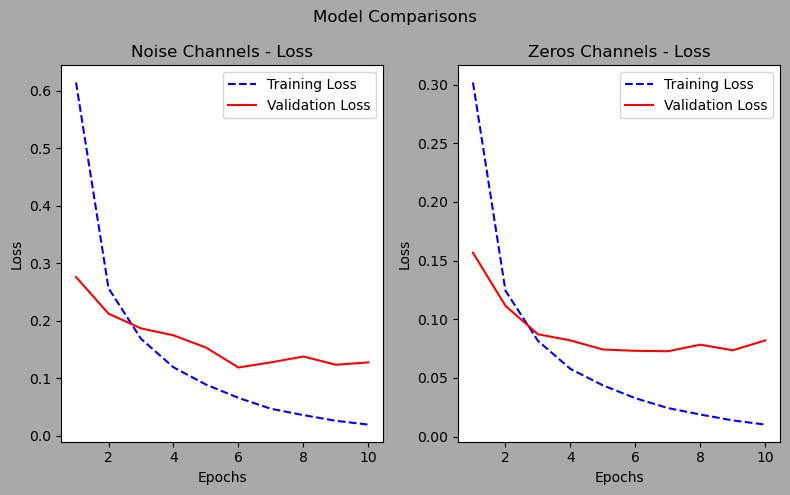

In [3]:
import keras
from keras import layers


def get_model():
    l1 = layers.Dense(512, activation="relu")
    output_layer = layers.Dense(10, activation="softmax")

    model = keras.Sequential()
    model.add(l1)
    model.add(output_layer)
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle("Model Comparisons")

# Model 1: Noise channels
fit_and_plot_results(
    model=get_model(),
    x_train=train_images_with_noise_channels,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Noise Channels",
    loss_only=True,
    axes=[axs[0]],
)

# Model 2: Zeros channels
fit_and_plot_results(
    model=get_model(),
    x_train=train_images_with_zeros_channels,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Zeros Channels",
    loss_only=True,
    axes=[axs[1]],
)

fig.tight_layout()
plt.show()

# 5.3 Improving Model Fit

## 5.3.1 Tuning Key Gradient Descent Parameters

If model doesn't get started - or stalls too early, we can overcome it by changing gradient descent parameters. This is always true.
If this happens try modifying learning rate or increasing batch size.


In [4]:
def get_model_rms_prop_change(learning_rate: float):
    model = keras.Sequential(
        [layers.Dense(512, activation="relu"), layers.Dense(10, activation="softmax")]
    )
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


fig, axs = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Model Comparisons")

# Learning rate 1.0
fit_and_plot_results(
    model=get_model_rms_prop_change(learning_rate=1.0),
    x_train=train_images,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Learning Rate 1",
    loss_only=True,
    axes=[axs[0]],
    start_at_idx=1,
)

# Learning rate 1e-2
fit_and_plot_results(
    model=get_model_rms_prop_change(learning_rate=1e-2),
    x_train=train_images,
    y_train=train_labels,
    n_epochs=10,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Learning Rate 1e-2",
    loss_only=True,
    axes=[axs[1]],
    start_at_idx=1,
)

# Learning rate 1e-2 with overfitting
fit_and_plot_results(
    model=get_model_rms_prop_change(learning_rate=1e-2),
    x_train=train_images,
    y_train=train_labels,
    n_epochs=20,
    batch_size=128,
    val_ratio=0.2,
    verbose=0,
    title="Learning Rate 1e-2 Overfitting",
    loss_only=True,
    axes=[axs[2]],
    start_at_idx=1,
)

fig.tight_layout()
plt.show()

# 5.4 Improving Generalization

## 5.4.1 Dataset curation

Skip for now.

## 5.4.2 Feature Engineering - skip

Skip for now.

## 5.4.3 Early Stopping - covered later

Skip for now.

## 5.4.4 Regularization

Impede model ability to find perfect fit.

### 5.4.4.1 Reduce Network Size

Smaller models tend to overfit less.


In [ ]:
from keras import datasets as kds